# **Classification**

#### Book used: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (third edition)

#### Chapter 3 practice: getting familiar with classification using the MNIST dataset

Defining default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Fetching the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Separating data from the labels and taking a look at what we have:

In [3]:
X, y = mnist.data, mnist.target

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

Each image has 784 features, because each image is 28x28 pixels and each feature represents the intensity of a pixel and ranges from 0 (white) to 255 (black). 

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Displaying one random image:

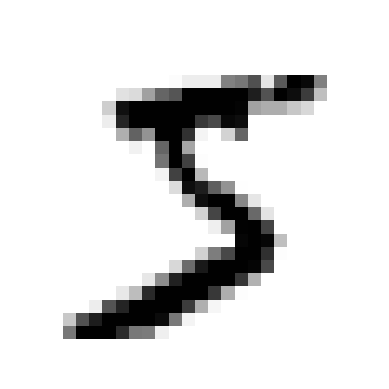

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

This dataset is already split into training (first 60,000 images) and testing sets (last 10,000 images) and the training set is already shuffled for us, ensuring that all cross-validation folds will be similar.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

Training a simple binary classifier to detect fives:

In [10]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

### Measuring accuracy using cross-validation

Using `cross_val_score` k-fold cross-validation with three folds (splitting the training set into k folds, then training the model k times, holding out a different fold for evaluation each time):

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Over 90% accuracy on each validation fold. However, this is not very impressive considering only about 10% of the images are 5. Therefore, if the classifier predicts "not 5" every time, it'll be correct about 90% of the time.

For this reason, accuracy isn't a very good performance measure for classifiers, especially when working with skewed datasets (where some classes are much more frequent than others.)

### Confusion matrix

Using a confusion matrix to check the accuracy of the model.

* Each row in a confusion matrix represents an actual class
* Each column represents a predicted class

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The first row of this confusion matrix considers non-5 images (the _negative class_): 53,892 were correctly classified as non-5s (_true negatives_) while the remaining 687 were incorrectly classified as 5s (_false positives_, also called _Type I errors_).

The second row considers the images of 5s (the _positive class_): 1,891 were wrongly classified as non-5s (_false negatives_, also called _Type II errors_), while the remaining 3,530 were correctly classified as 5s (_true positives_).

What a confusion matrix would look like if the model were perfect:

In [16]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and recall

Precision of the classifier can be given by:

$$Precision = \frac{TP}{TP + FP},$$

where TP is the number of true positives, and FP is the number of false positives.

Precision is usually used along with another metric named _recall_, also called _sensitivity_ or _true positive rate (TPR)_. This is the ratio of positive instances that are correctly detected by the classifier:

$$Recall = \frac{TP}{TP + FN},$$

where FN is the number of false negatives.

Scikit-Learn contains functions that can calculate these easily:

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

As we can see, when the classifier claimed an image represented a 5, it was only correct about 83.7% of the time.
Additionally, it only detected 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_{1}$ score, especially when you need a single metric to compare two classifiers:

$$F_{1} score = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

The $F_{1}$ score is a common metric used in binary classification tasks to evaluate the performance of a classification model. It is the harmonic mean of the precision and recall of the model, and ranges from 0 to 1, where a score of 1 indicates perfect precision and recall, and a score of 0 indicates poor performance.

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall tradeoff

There's a tradeoff between precision and recall. This is visualized in the following graph, showing precision and recall for all possible decision thresholds (the cut-off for deciding either a positive or negative classification):

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Showing an example threshold of 3000 on the graph to see what the values of precision and recall would be:

In [22]:
threshold = 3000

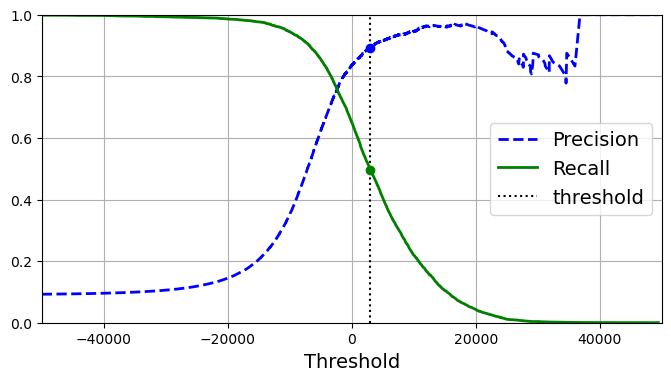

In [23]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies the figure
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At this threshold value, precision is around 90% and recall is around 50%. Another way to visualize this is by plotting precision directly against recall:

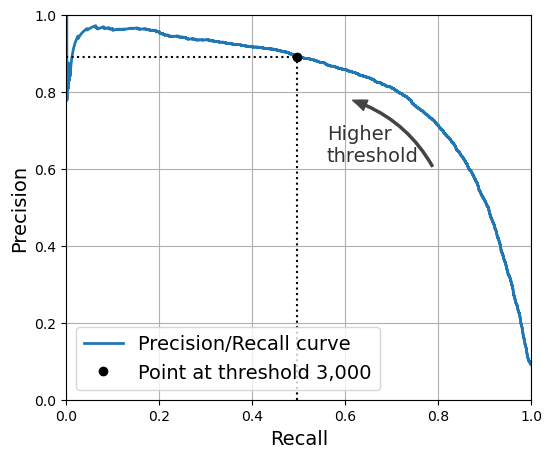

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies the figure
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Evidently, precision really starts to fall sharply at around 80% recall. A good threshold would probably be just before that drop, around 60%. But it depends on the project.

If one decides to aim for 90% precision it can be done using the previous diagram, but a better way would be to use the NumPy array's `argmax()` method, which returns the first index of the maximum value, which in this case means the first True value:

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499143957

Making predictions on the training set:

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Checking precision and recall:

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

90% precision was achieved, as expected!

In [28]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Clearly, it's quite easy to create a classifier of any predetermined precision. However, 48% recall isn't very good for most applications.

**A high-precision classifier is not very useful if its recall is too low!**

### The ROC curve